## Exploring the Correlation Between Street Network Attributes and Traffic Collisions:Based on Space Syntax


Hypothesis area: Downtown, Los Angeles

Data Source:
1. traffic collision data: [Los Angeles Open Data](https://data.lacity.org/Public-Safety/Traffic-Collision-Data-from-2010-to-Present/d5tf-ez2w)

2. LA city neighborhood boundaries data: [Los Angeles Geo Hub](https://geohub.lacity.org/datasets/d6c55385a0e749519f238b77135eafac_0/explore?location=34.020320%2C-118.410084%2C10.51)

3. LA city street data: [Los Angeles Geo Hub](https://geohub.lacity.org/datasets/lahub::streets-centerline/explore)

4. street network data: from osmnx library

Table of Contents:
1. Clean Data
2. Create Variables
3. Conduct Regression
4. Conclusion

## 1. Clean Data
In order to conduct the analysis, traffic accident data of the city of Los Angeles area was collected and the frequency of traffic accidents from 2018 to 2022 was organized by neighborhood. As a result, it was determined that during the specified period, Downtown area of the city of Los Angeles experienced the highest number of traffic accidents. Consequently, the relationship between traffic accidents and the street network within that area was examined. To perform this analysis, Downtown road data from LA city was extracted, and the extracted Downtown street geodataframe was then converted into a multidigraph to facilitate the investigation of the street network.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import osmnx as ox
import networkx as nx
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from shapely.geometry import Polygon, Point, LineString, MultiPoint
import matplotlib.pyplot as plt
import pickle
import esda
from libpysal import weights
from scipy import stats
from scipy.stats import gaussian_kde
from matplotlib.colors import ListedColormap
from geopandas import sjoin
import contextily as ctx
import spreg
import mgwr
import random
from collections import defaultdict
import math
from geopy.distance import great_circle
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations

In [2]:
from Functions.functions import gdf_to_multidigraph
from Functions.functions import add_node_coordinates
from Functions.functions import collapse_multidigraph_to_digraph
from Functions.functions import nearest_edge
from Functions.functions import get_cmap

In [3]:
from Functions.space_syntax import calculate_connectivity
from Functions.space_syntax import calculate_edge_choice
from Functions.space_syntax import calculate_centrality

In [4]:
# import raw data of total traffic collisions in Los Angeles
tc_total=pd.read_csv('Data/Traffic_Collision_Data_from_2010_to_Present.csv')

In [5]:
# extract data from 2018 to 2022
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2022-12-31')
tc_total['Date Occurred'] = pd.to_datetime(tc_total['Date Occurred'])
tc = tc_total[(tc_total['Date Occurred'] >= start_date) & (tc_total['Date Occurred'] <= end_date)]
tc

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Address,Cross Street,Location
0,190319651,08/24/2019,2019-08-24,450,3,Southwest,356,997,TRAFFIC COLLISION,3036 3004 3026 3101 4003,22.0,M,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)"
1,190319680,08/30/2019,2019-08-30,2320,3,Southwest,355,997,TRAFFIC COLLISION,3037 3006 3028 3030 3039 3101 4003,30.0,F,H,101.0,STREET,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)"
2,190413769,08/25/2019,2019-08-25,545,4,Hollenbeck,422,997,TRAFFIC COLLISION,3101 3401 3701 3006 3030,NaN,M,X,101.0,STREET,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)"
3,190127578,11/20/2019,2019-11-20,350,1,Central,128,997,TRAFFIC COLLISION,0605 3101 3401 3701 3011 3034,21.0,M,H,101.0,STREET,1ST,CENTRAL,"(34.0492, -118.2391)"
4,190319695,08/30/2019,2019-08-30,2100,3,Southwest,374,997,TRAFFIC COLLISION,0605 4025 3037 3004 3025 3101,49.0,M,B,101.0,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587794,231005773,02/15/2023,2022-02-15,2100,10,West Valley,1047,997,TRAFFIC COLLISION,3006 3028 4026 3030 3033 3035,37.0,F,W,101.0,STREET,ALDEA,COLLINS,"(34.1742, -118.5076)"
587804,231905799,02/11/2023,2022-02-11,155,19,Mission,1901,997,TRAFFIC COLLISION,3028 3006 3030 3037 3101 4019,45.0,M,W,101.0,STREET,FOOTHILL BL,YARNELL ST,"(34.3213, -118.4792)"
587811,230107092,12/18/2022,2022-12-17,830,1,Central,142,997,TRAFFIC COLLISION,0605 3030 4024,65.0,M,H,101.0,STREET,W 4TH ST,S FIGUEROA,"(34.0535, -118.256)"
587824,231405761,02/13/2023,2022-10-23,1520,14,Pacific,1444,997,TRAFFIC COLLISION,3004 3025 4027,32.0,F,W,101.0,STREET,LINCOLN BL,WASHINGTON BL,"(33.9905, -118.4478)"


In [6]:
# convert tc into geodataframe
latlon = []
for location in tc['Location']:
    lat, lon = map(float, location[1:-1].split(','))
    x = Point(lon, lat)
    latlon.append(x)

tc['geometry'] = latlon
tc_gdf = gpd.GeoDataFrame(tc, geometry='geometry')
tc_gdf.crs = 'EPSG:4326'

tc_gdf

/var/folders/nh/bgd128891hxd7ggprg1zgbhm0000gn/T/ipykernel_52512/1143413870.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tc['geometry'] = latlon


,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Address,Cross Street,Location,geometry
0,190319651,08/24/2019,2019-08-24,450,3,Southwest,356,997,TRAFFIC COLLISION,3036 3004 3026 3101 4003,22.0,M,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",POINT (-118.30020 34.02550)
1,190319680,08/30/2019,2019-08-30,2320,3,Southwest,355,997,TRAFFIC COLLISION,3037 3006 3028 3030 3039 3101 4003,30.0,F,H,101.0,STREET,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)",POINT (-118.30890 34.02560)
2,190413769,08/25/2019,2019-08-25,545,4,Hollenbeck,422,997,TRAFFIC COLLISION,3101 3401 3701 3006 3030,NaN,M,X,101.0,STREET,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)",POINT (-118.20780 34.07380)
3,190127578,11/20/2019,2019-11-20,350,1,Central,128,997,TRAFFIC COLLISION,0605 3101 3401 3701 3011 3034,21.0,M,H,101.0,STREET,1ST,CENTRAL,"(34.0492, -118.2391)",POINT (-118.23910 34.04920)
4,190319695,08/30/2019,2019-08-30,2100,3,Southwest,374,997,TRAFFIC COLLISION,0605 4025 3037 3004 3025 3101,49.0,M,B,101.0,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)",POINT (-118.31820 34.01080)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587794,231005773,02/15/2023,2022-02-15,2100,10,West Valley,1047,997,TRAFFIC COLLISION,3006 3028 4026 3030 3033 3035,37.0,F,W,101.0,STREET,ALDEA,COLLINS,"(34.1742, -118.5076)",POINT (-118.50760 34.17420)
587804,231905799,02/11/2023,2022-02-11,155,19,Mission,1901,997,TRAFFIC COLLISION,3028 3006 3030 3037 3101 4019,45.0,M,W,101.0,STREET,FOOTHILL BL,YARNELL ST,"(34.3213, -118.4792)",POINT (-118.47920 34.32130)
587811,230107092,12/18/2022,2022-12-17,830,1,Central,142,997,TRAFFIC COLLISION,0605 3030 4024,65.0,M,H,101.0,STREET,W 4TH ST,S FIGUEROA,"(34.0535, -118.256)",POINT (-118.25600 34.05350)
587824,231405761,02/13/2023,2022-10-23,1520,14,Pacific,1444,997,TRAFFIC COLLISION,3004 3025 4027,32.0,F,W,101.0,STREET,LINCOLN BL,WASHINGTON BL,"(33.9905, -118.4478)",POINT (-118.44780 33.99050)


<Axes: >

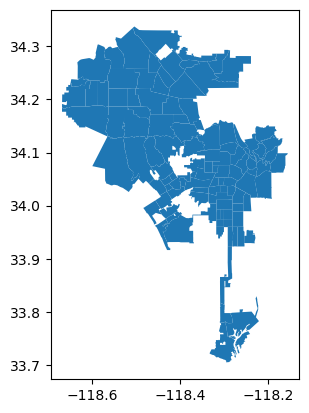

In [7]:
# import LA neighborhood data
la_city = gpd.read_file('Data/LA_Times_Neighborhood_Boundaries/LA_Times_Neighborhood_Boundaries.shp')
la_city.plot()

In [8]:
# make sure lacity map and traffic collision data have same crs
la_city.crs='EPSG:4326'
tc_gdf.crs='EPSG:4326'

In [9]:
# perform spatial join
collisions_by_neighborhood = gpd.sjoin(tc_gdf, la_city, op='within')
collisions_by_neighborhood

/Users/kweon-youngseo/miniforge3/envs/ppd599/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Victim Descent,Premise Code,Premise Description,Address,Cross Street,Location,geometry,index_right,OBJECTID,name
0,190319651,08/24/2019,2019-08-24,450,3,Southwest,356,997,TRAFFIC COLLISION,3036 3004 3026 3101 4003,...,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",POINT (-118.30020 34.02550),31,32,Exposition Park
8,190319702,08/31/2019,2019-08-31,1330,3,Southwest,356,997,TRAFFIC COLLISION,3036 4025 3004 3026 3101,...,H,101.0,STREET,WESTERN AV,36TH ST,"(34.0228, -118.3089)",POINT (-118.30890 34.02280),31,32,Exposition Park
20,190319635,08/28/2019,2019-08-28,1855,3,Southwest,356,997,TRAFFIC COLLISION,3036 3004 3026 3034 3101,...,B,101.0,STREET,WESTERN,37TH ST,"(34.0211, -118.3089)",POINT (-118.30890 34.02110),31,32,Exposition Park
476,190319787,09/01/2019,2019-09-01,700,3,Southwest,377,997,TRAFFIC COLLISION,4025 3037 0101 3004 3006 3024 3101,...,B,101.0,STREET,MARTIN LUTHER KING JR BL,BUDLONG AV,"(34.0109, -118.2959)",POINT (-118.29590 34.01090),31,32,Exposition Park
516,190319732,09/01/2019,2019-08-31,1850,3,Southwest,357,997,TRAFFIC COLLISION,4025 3037 3003 3024 3101,...,B,101.0,STREET,37TH ST,NORMANDIE AV,"(34.021, -118.3002)",POINT (-118.30020 34.02100),31,32,Exposition Park
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583153,221614007,11/05/2022,2022-11-03,1015,16,Foothill,1608,997,TRAFFIC COLLISION,4026 3004 3026 3036 3101,...,H,101.0,STREET,FOOTHILL BL,WHEATLAND AV,"(34.2733, -118.3528)",POINT (-118.35280 34.27330),53,54,Lake View Terrace
584049,221614486,11/22/2022,2022-11-21,1730,16,Foothill,1602,997,TRAFFIC COLLISION,3101 3602 3009 3024 4016 3037,...,H,101.0,STREET,FOOTHILL BL,PAXTON ST,"(34.2867, -118.408)",POINT (-118.40800 34.28670),53,54,Lake View Terrace
584902,221615162,12/14/2022,2022-12-14,2020,16,Foothill,1605,997,TRAFFIC COLLISION,3101 3004 3026 4026 3029 3036,...,W,101.0,STREET,PIERCE ST,GLADSTONE AV,"(34.2802, -118.3954)",POINT (-118.39540 34.28020),53,54,Lake View Terrace
585617,221615590,12/29/2022,2022-12-29,12,16,Foothill,1606,997,TRAFFIC COLLISION,3011 3028 4016 3030 3034 3037 3101,...,X,101.0,STREET,FOOTHILL BL,OSBORNE ST,"(34.276, -118.3783)",POINT (-118.37830 34.27600),53,54,Lake View Terrace


In [10]:
# count the number of traffic collisions in each neighborhood
collisions_count = collisions_by_neighborhood.groupby('name').size()
collisions_count

# convert the result to a DataFrame and reset the index
collisions_count = pd.DataFrame(collisions_count, columns=['collision_count']).reset_index()

# sort values in descending order
collisions_count.sort_values('collision_count', ascending=False)

,name,collision_count
23,Downtown,9213
97,Van Nuys,6024
47,Hollywood,5787
52,Koreatown,4981
108,Westlake,4814
...,...,...
19,Cheviot Hills,206
65,Mount Washington,191
40,Hansen Dam,109
8,Beverlywood,105


After arranging the values of traffic accident occurrence in a descending order, it was observed that Downtown had the greatest number of occurrences. Therefore, Downtown has been designated as the hypothesis area.

In [11]:
# merge neighborhood data and collisions count
neighborhoods_collisionscount = la_city.merge(collisions_count, on='name')
neighborhoods_collisionscount

,OBJECTID,name,geometry,collision_count
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",559
1,2,Arleta,"POLYGON ((-118.44255 34.26412, -118.44240 34.2...",1024
2,3,Arlington Heights,"POLYGON ((-118.31862 34.05306, -118.31673 34.0...",1057
3,4,Atwater Village,"MULTIPOLYGON (((-118.27886 34.15321, -118.2788...",478
4,5,Baldwin Hills/Crenshaw,"POLYGON ((-118.36102 34.02532, -118.36026 34.0...",1537
...,...,...,...,...
109,110,Wilmington,"MULTIPOLYGON (((-118.28331 33.75532, -118.2880...",2398
110,111,Windsor Square,"POLYGON ((-118.31404 34.06254, -118.31420 34.0...",380
111,112,Winnetka,"POLYGON ((-118.56232 34.23199, -118.56232 34.2...",2248
112,113,Woodland Hills,"POLYGON ((-118.57240 34.18668, -118.57161 34.1...",2424


In [12]:
# find collisions in downtown
collisions_downtown = collisions_by_neighborhood[collisions_by_neighborhood['name']=='Downtown']
collisions_downtown = collisions_downtown.drop('index_right', axis=1)
collisions_downtown

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Victim Sex,Victim Descent,Premise Code,Premise Description,Address,Cross Street,Location,geometry,OBJECTID,name
3,190127578,11/20/2019,2019-11-20,350,1,Central,128,997,TRAFFIC COLLISION,0605 3101 3401 3701 3011 3034,...,M,H,101.0,STREET,1ST,CENTRAL,"(34.0492, -118.2391)",POINT (-118.23910 34.04920),24,Downtown
44,210119138,10/24/2021,2021-10-24,135,1,Central,141,997,TRAFFIC COLLISION,3401 3701 3036 3035 3004 3026 3029 3101 4024,...,M,B,101.0,STREET,4TH,FIGUEROA,"(34.0538, -118.256)",POINT (-118.25600 34.05380),24,Downtown
66,200113538,06/17/2020,2020-06-14,2030,1,Central,195,997,TRAFFIC COLLISION,0605 3101 3401 3701 3006 3030 1501,...,F,H,101.0,STREET,15TH,MAPLE,"(34.0326, -118.2589)",POINT (-118.25890 34.03260),24,Downtown
72,210113189,07/09/2021,2021-07-08,2205,1,Central,176,997,TRAFFIC COLLISION,3003 3025 3029 3037 1218 3101 4024 0605 3401 3701,...,M,B,101.0,STREET,SAN PEDRO,8TH,"(34.0385, -118.2491)",POINT (-118.24910 34.03850),24,Downtown
211,191317613,08/28/2019,2019-08-27,1340,13,Newton,1317,997,TRAFFIC COLLISION,1501 3101 3401 3701 3004 3030,...,M,H,101.0,STREET,SAN PEDRO,WASHINGTON,"(34.0245, -118.244)",POINT (-118.24400 34.02450),24,Downtown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586262,220110217,04/13/2022,2022-04-13,830,1,Central,134,997,TRAFFIC COLLISION,0605 3004 3028 3034 4024 3101 3401 3701 3036 3033,...,M,A,101.0,STREET,4TH ST,SPRING ST,"(34.0492, -118.2488)",POINT (-118.24880 34.04920),24,Downtown
586305,230105275,01/20/2023,2022-10-02,1800,1,Central,148,997,TRAFFIC COLLISION,0605 3008 3033 3036 3101 3401 3701 4001 3029 3025,...,M,H,101.0,STREET,5TH ST,GLADYS AV,"(34.0421, -118.2405)",POINT (-118.24050 34.04210),24,Downtown
587408,231305907,01/17/2023,2022-11-25,1110,13,Newton,1307,997,TRAFFIC COLLISION,0605 3030 4024,...,F,B,101.0,STREET,1000 E 7TH ST,NaN,"(34.0385, -118.2437)",POINT (-118.24370 34.03850),24,Downtown
587638,230106871,12/31/2022,2022-12-31,1225,1,Central,162,997,TRAFFIC COLLISION,0605 3030 4024,...,M,W,101.0,STREET,W 8TH ST,S OLIVE ST,"(34.0452, -118.2569)",POINT (-118.25690 34.04520),24,Downtown


In [13]:
# import streets data in LA city
streets = gpd.read_file('Data/Streets_(Centerline)/Streets_(Centerline).shp')

In [14]:
# check crs coordinance
collisions_downtown.crs == streets.crs

True

<Axes: >

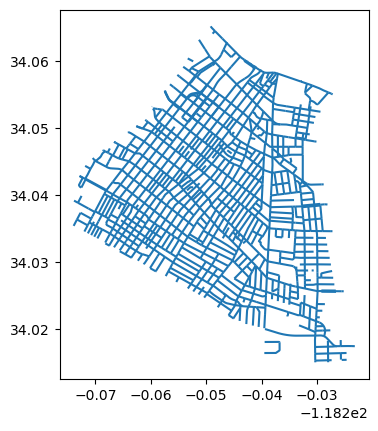

In [15]:
# select Downtown boundary from la_city
d_bound = la_city[la_city['name']=='Downtown']

# spatial join between streets and Downtown area to get the streets within Downtown
d_streets = gpd.overlay(streets, d_bound, how='intersection')

d_streets.plot()

In [16]:
# convert d_streets to MultiDiGraph
G_d = gdf_to_multidigraph(d_streets)

In [17]:
# add node information to created G_d with d_streets
add_node_coordinates(G_d, d_streets)

In [18]:
# simplify G_d
G_d = collapse_multidigraph_to_digraph(G_d)

In [19]:
# for analysis, convert the DiGraph G_d to MultiDiGraph G_d
G_d = nx.MultiDiGraph(G_d)

In [20]:
# convert 'G_d' into two GeoDataFrames
#'gdf_nodes' for the nodes and 'gdf_edges' for the edges
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_d) 

<Axes: >

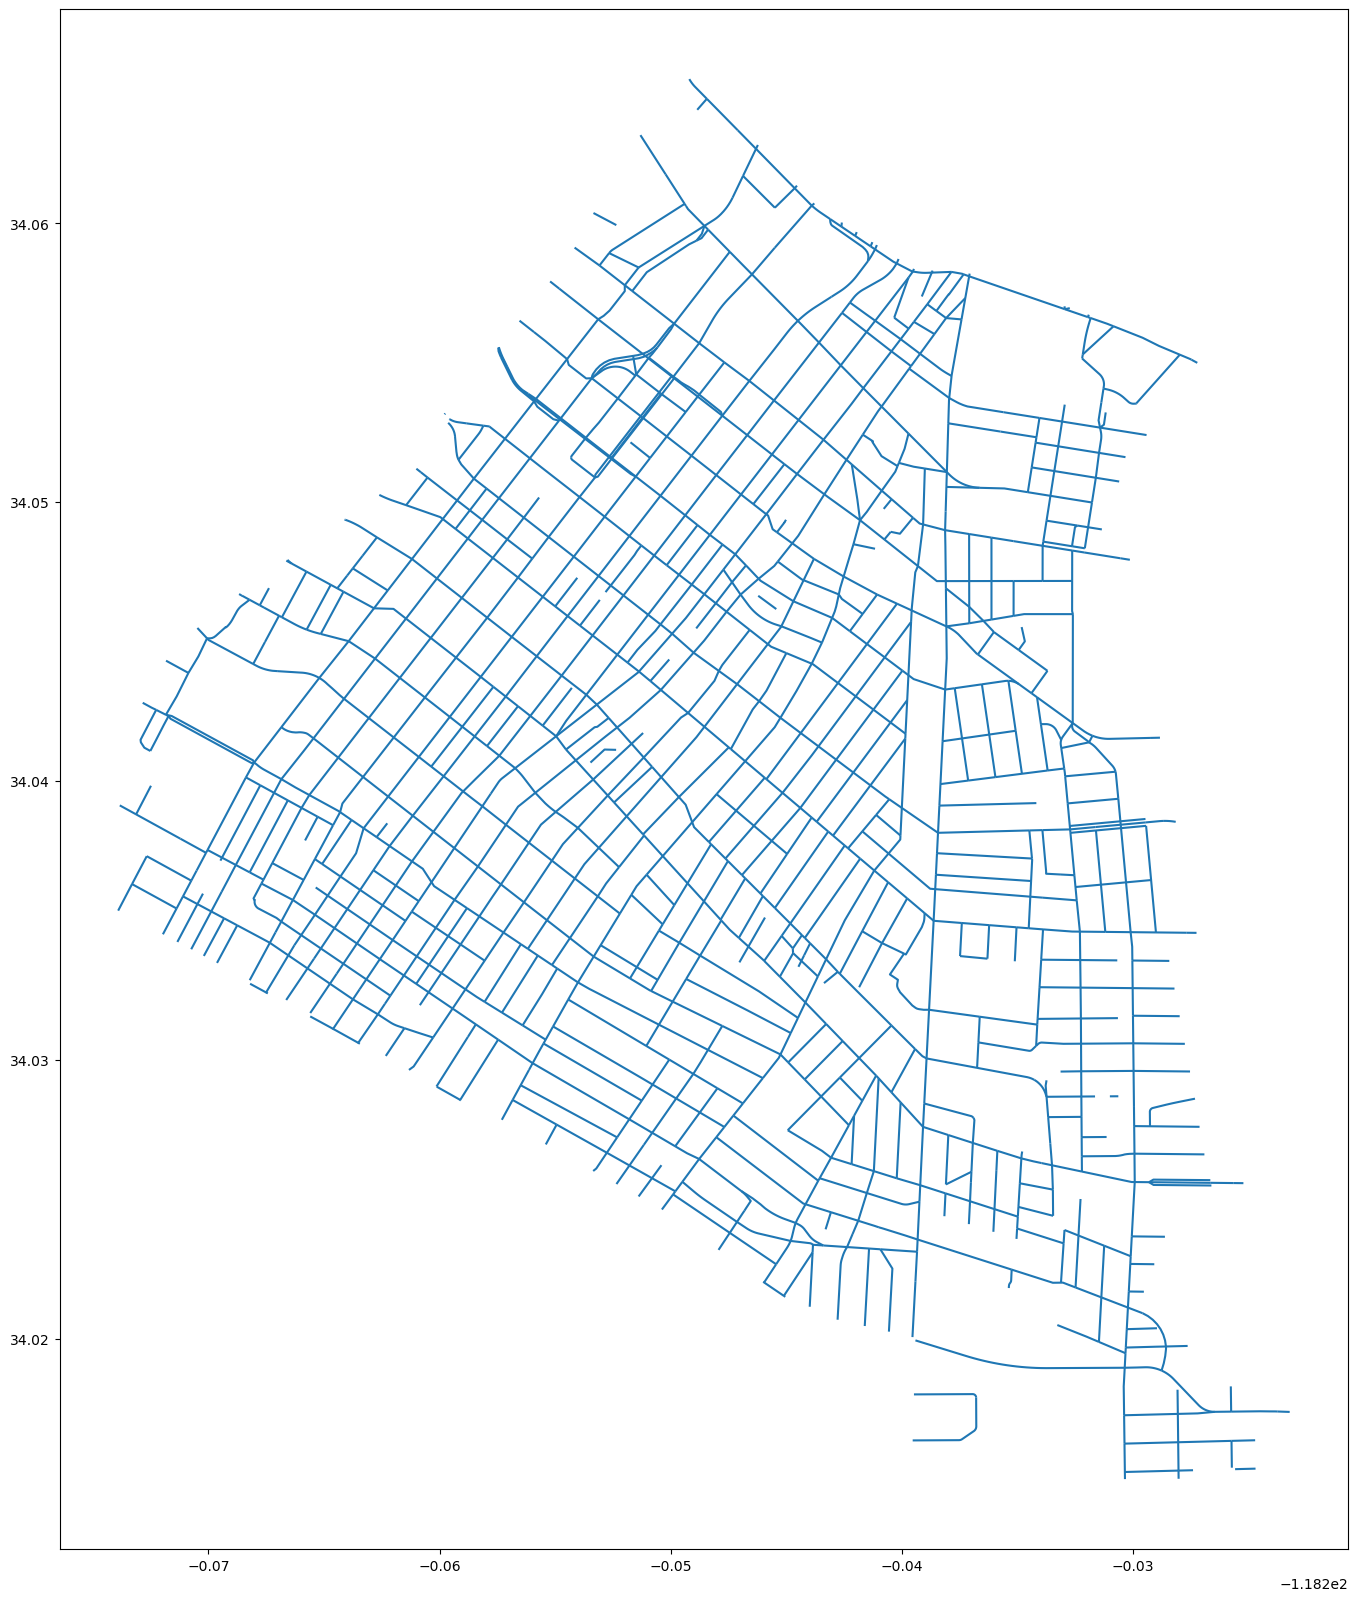

In [21]:
# plot gdf_edges to compare with d_streets
gdf_edges.plot(figsize=(20,20))

In [22]:
gdf_edges

ASSETID    STNUM   MAPSHEET        ID    ADRF    ADRT   
u     v     key                                                          
5370  5372  0        222   1164.0  121-5A211    9254.0  1200.0  1298.0  \
      46168 0      58763   6815.0  121-5A211   10430.0  1801.0  1839.0   
5372  41759 0      51531   8079.0  121-5A211    9583.0  1801.0  1803.0   
41759 46165 0      11917   8079.0    120A211   77636.0  1805.0  1839.0   
      5393  0      28982   1164.0    120A211   66445.0  1300.0  1398.0   
...                  ...      ...        ...       ...     ...     ...   
66533 66532 0     175015  11561.0    126A207  106332.0  1229.0  1249.0   
44109 8646  0      11807   2935.0    129A211   15364.0   621.0   699.0   
43112 8941  0      58536   4441.0    129A209   71598.0   601.0   699.0   
8803  8804  0      77058   5145.0  124-5A205   14983.0  1701.0  1799.0   
64886 8273  0     167460   1627.0    129A213  101984.0   301.0   399.0   

                   ZIP_R    ADLF    ADLT    ZIP_L  ... Planning_A      TYPE   
u     v     key                                    ...                        
5370  5372  0    90021.0  1201.0  1299.0  90021.0  ...      222.0      70.0  \
      46168 0    90021.0  1800.0  1838.0  90021.0  ...    58763.0      70.0   
5372  41759 0    90021.0  1790.0  1798.0  90021.0  ...    51531.0      40.0   
41759 46165 0    90021.0  1800.0  1838.0  90021.0  ...    11917.0      40.0   
      5393  0    90021.0  1301.0  1399.0  90021.0  ...    28982.0      70.0   
...                  ...     ...     ...      ...  ...        ...       ...   
66533 66532 0    90015.0  1228.0  1248.0  90015.0  ...   175015.0  180000.0   
44109 8646  0    90014.0   620.0   698.0  90014.0  ...    11807.0   60500.0   
43112 8941  0    90014.0   600.0   698.0  90014.0  ...    58536.0   60500.0   
8803  8804  0    90015.0  1700.0  1798.0  90015.0  ...    77058.0      70.0   
64886 8273  0    90012.0   300.0   398.0  90012.0  ...   167460.0   60500.0   

                MODIFIED               Street_Des               Street_D_1   
u     v     key                                                              
5370  5372  0        0.0  Local Street - Standard  Local Street - Standard  \
      46168 0        0.0  Local Street - Standard  Local Street - Standard   
5372  41759 0        0.0                Avenue II                Avenue II   
41759 46165 0        0.0                Avenue II                Avenue II   
      5393  0        0.0  Local Street - Standard  Local Street - Standard   
...                  ...                      ...                      ...   
66533 66532 0        0.0                  Private                  Private   
44109 8646  0        0.0                    Alley                    Alley   
43112 8941  0        0.0                    Alley                    Alley   
8803  8804  0        0.0  Local Street - Standard  Local Street - Standard   
64886 8273  0        1.0           Modified Alley                    Alley   

                AutoID OBJECTID_1 OBJECTID_2      name   
u     v     key                                          
5370  5372  0       53         54         24  Downtown  \
      46168 0    54174      56466         24  Downtown   
5372  41759 0    45759      47707         24  Downtown   
41759 46165 0     9347       9709         24  Downtown   
      5393  0    26642      27773         24  Downtown   
...                ...        ...        ...       ...   
66533 66532 0    84582      90334         24  Downtown   
44109 8646  0    84633      90391         24  Downtown   
43112 8941  0    84682      90441         24  Downtown   
8803  8804  0    84703      90463         24  Downtown   
64886 8273  0    84713      90474         24  Downtown   

                                                          geometry  
u     v     key                                                     
5370  5372  0    LINESTRING (-118.25081 34.02576, -118.24980 34...  
      46168 0    LINESTRING (-118.25081 34.02576,

In the Downtown traffic accident data, the objective was to determine which edges in the graph G_d were associated with the accidents using the geometry data, and to find out the number of accidents that occurred on each edge. An attempt was made to perform a spatial join using the sjoin function; however, it was not feasible due to slight misalignments between the collision_downtown and G_d geometries, even though they appeared to overlap visually. Therefore, the closest edge to each point in collision_downtown was identified, and the traffic accident count was incremented for that edge.

In [23]:
# initialize the edges with an empty collision count attribute
for u, v, k, data in G_d.edges(data=True, keys=True):
    data['collision_count'] = 0

In [24]:
# find the nearest edge to each traffic accident point and update the count
for index, collision in collisions_downtown.iterrows():
    # get the coordinates of the collision point
    point = (collision.geometry.y, collision.geometry.x)
    # find the nearest edge to the collision point
    u, v, k = nearest_edge(point, G_d)
    # add the collision count for the nearest edge
    G_d[u][v][k]['collision_count'] += 1

In [25]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_d)

In [26]:
# verify if all the collisions were counted
gdf_edges['collision_count'].sum()

9213

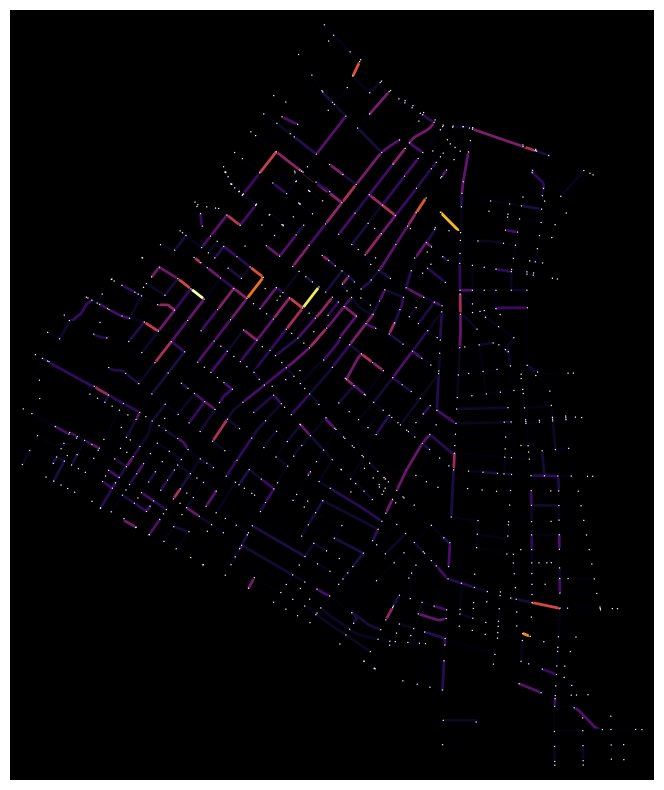

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [27]:
# visualize 'collision_count' on G_d
fig, ax = plt.subplots(figsize=(10,10))
ec = ox.plot.get_edge_colors_by_attr(G_d, 'collision_count', cmap='inferno')
ax.set_facecolor('black')
ox.plot_graph(G_d, edge_color=ec, edge_linewidth=2, node_size=1, ax=ax)

# fig.savefig('Image/collision_count.png', bbox_inches='tight')

It has been observed that the frequency of traffic accidents appears to be relatively higher in the central part of the neighborhood.  Then, an additional analysis has been carried out to determine hot/cold spots, facilitating the visualization of locations with a dense accumulation of collisions.

In [28]:
# extract the coordinates of traffic collision points
accidents_points = collisions_downtown.geometry.apply(lambda p: [p.x, p.y]).tolist()

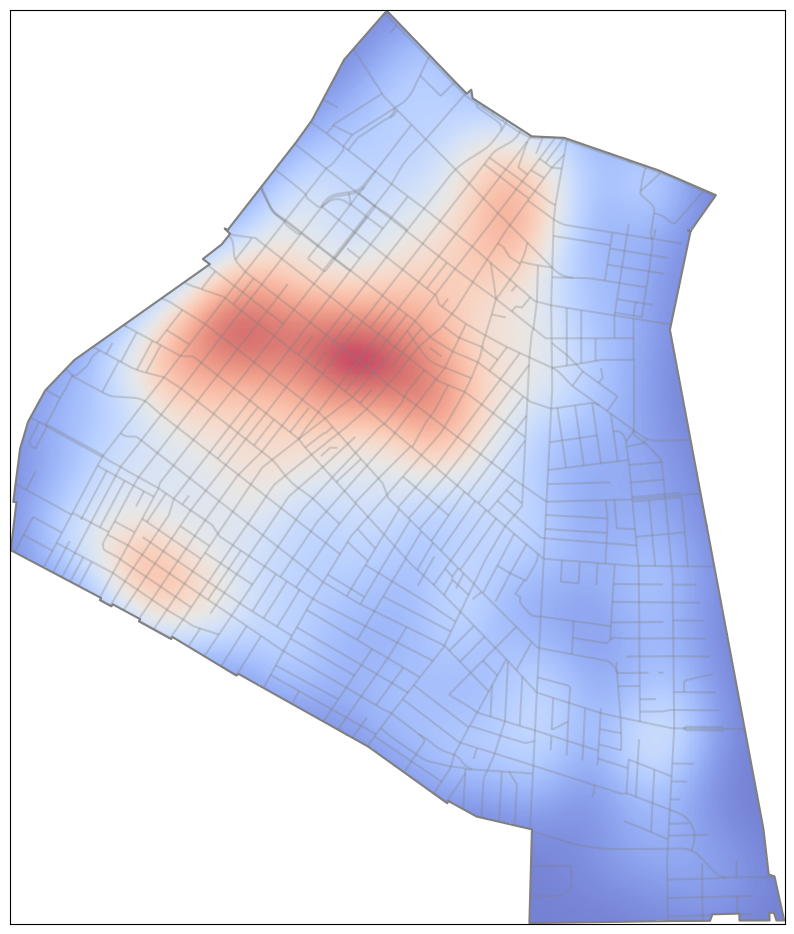

In [29]:
# create a grid within the boundaries of LA downtown
downtown_bounds = d_bound.geometry.bounds.iloc[0]
x_min, y_min, x_max, y_max = downtown_bounds
x_grid, y_grid = np.mgrid[x_min:x_max:500j, y_min:y_max:500j]

# extract the center points of the grid cells
grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

# calculate KDE
kde = gaussian_kde(np.array(accidents_points).T)
grid_density = kde(grid_points.T).reshape(x_grid.shape)

# clip values within the boundary
downtown_mask = np.zeros_like(x_grid, dtype=bool)
for polygon in d_bound.geometry:
    for x in range(x_grid.shape[0]):
        for y in range(x_grid.shape[1]):
            point = Point(x_grid[x, y], y_grid[x, y])
            if polygon.contains(point):
                downtown_mask[x, y] = True
                
masked_density = np.ma.array(grid_density, mask=~downtown_mask)

# visualization
fig, ax = plt.subplots(figsize=(10,12))
d_bound.boundary.plot(ax=ax, color="gray")
gdf_edges.plot(ax=ax, color='gray', alpha=0.3)

cmap = ListedColormap(sns.color_palette("coolwarm", n_colors=256).as_hex())
plt.pcolormesh(x_grid, y_grid, masked_density, cmap=cmap, alpha=0.7)

# Remove x and y ticks and labels
plt.xticks([])
plt.yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# plt.savefig("Image/Los_Angeles_Downtown_Traffic_Collision_Hot_Cold_spots.png", bbox_inches='tight')

plt.show()


Upon analyzing the hot/cold spot map, it was observed that the outcomes were similar to those previously obtained from the visualization of edges based on the frequency of traffic accidents. This discovery supports the idea that most traffic accidents in the downtown area occur near the center of the neighborhood.

## 2. Create Variables

In order to conduct the analysis, the following street network attributes were calculated: depth, betweenness, connectivity, and centrality.

### 2-1. Connectivity
Connectivity measures the number of spaces immediately connecting a space of origin. Connectivity is a fundamental concept in space syntax, which measures the immediate connectivity of a space to other spaces. While space syntax usually calculates connectivity on the node level, I calculated the connectivity of edges in the road network. To do this, I used the out_edges() function to count the number of edges that depart from each node and summed these values to calculate the connectivity between the origin and destination nodes of each edge.

- Edges with high connectivity values: Edges with high connectivity values in the road network have strong connections with other edges, indicating their potential to play a significant role in transportation and impact traffic flow. 
- Edges with low connectivity values: Edges with low connectivity values have weaker connections with other edges and are considered less important in the road network.

[UCL Space Syntax: Connectivity](https://www.spacesyntax.online/term/connectivity/)

In [30]:
connectivity_dict = calculate_connectivity(G_d)

In [31]:
pd.Series(connectivity_dict).describe()

count    1530.000000
mean        3.447712
std         0.938361
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         7.000000
dtype: float64

In [32]:
# add attribute
nx.set_edge_attributes(G_d, connectivity_dict, 'connectivity')

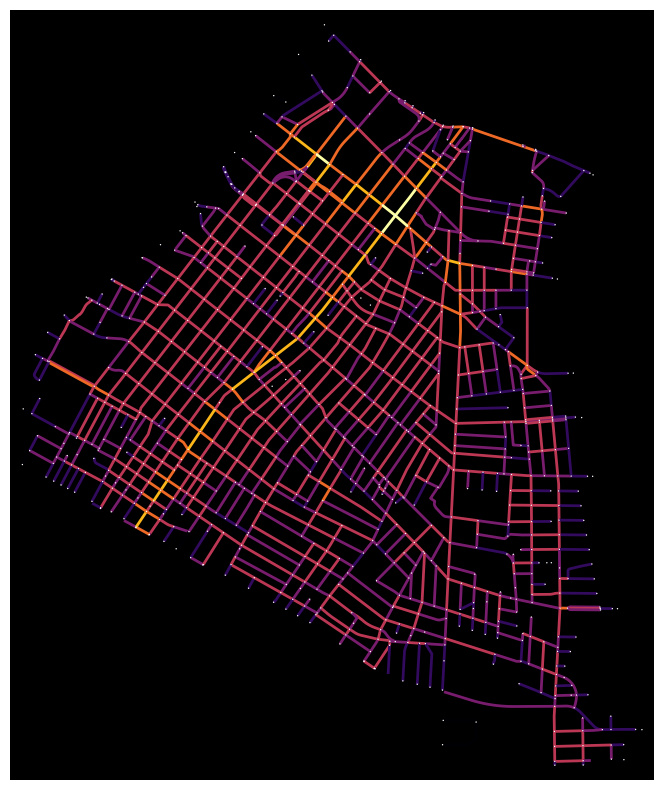

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [33]:
# visualize 'connectivity' on G_d
fig, ax = plt.subplots(figsize=(10,10))
ec = ox.plot.get_edge_colors_by_attr(G_d, 'connectivity', cmap='inferno')
ax.set_facecolor('black')
ox.plot_graph(G_d, edge_color=ec, edge_linewidth=2, node_size=1, ax=ax)

# fig.savefig('Image/connectivity.png', bbox_inches='tight')

Above is the visualization of connectivity. There are a high connectivity edges that go though the region in the middle.

### 2-2. Betweenness
Betweenness Centrality is a measure for quantifying the probability that a street segment falls on a randomly selected shortest path linking any pair of segments.I have calculated Betweenness Centrality for edges.

- Edges with high Betweenness Centrality values:
Edges with high Betweenness Centrality values are interpreted as crucial in the road network as they are frequently located on the shortest paths connecting any two given pairs of edges. These edges exhibit high levels of connectivity with other edges and can significantly impact traffic flow. 
- Edges with low Betweenness Centrality values:
Eedges with low Betweenness Centrality values are interpreted as having relatively low importance within the road network, as they are less frequently located on the shortest paths connecting any two given pairs of edges. These edges possess a lower degree of connectivity with surrounding roads and are less likely to affect traffic flow substantially. 

[UCL Space Syntax: Betweenness Centrality](https://www.spacesyntax.online/term/betweeness/)

In [34]:
# calculate betweenness
betweenness = nx.betweenness_centrality(nx.line_graph(G_d), normalized=False)

In [35]:
# add attribute
nx.set_edge_attributes(G_d, betweenness, 'betweenness')

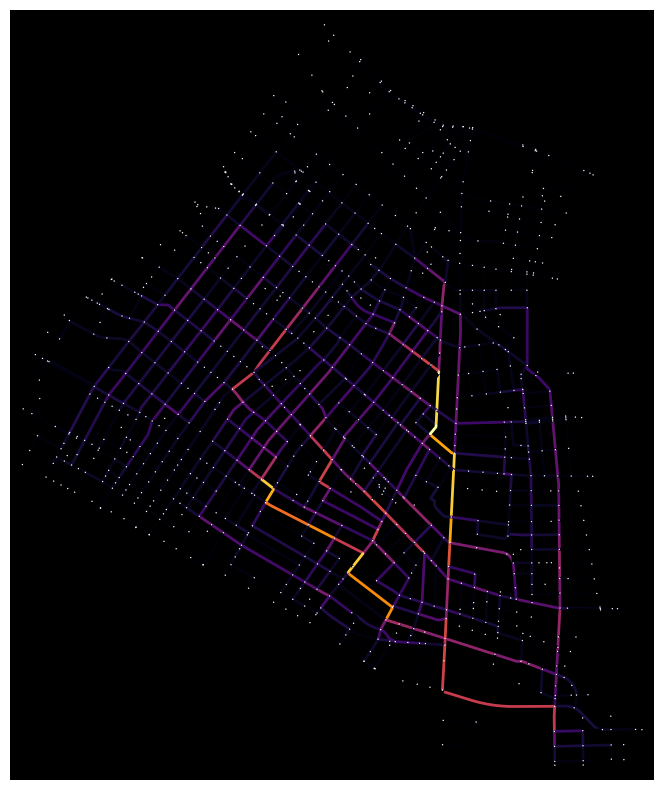

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [36]:
# visualize 'betweenness' on G_d
fig, ax = plt.subplots(figsize=(10,10))
ec = ox.plot.get_edge_colors_by_attr(G_d, 'betweenness', cmap='inferno')
ax.set_facecolor('black')
ox.plot_graph(G_d, edge_color=ec, edge_linewidth=2, node_size=1, ax=ax)

# fig.savefig('Image/betweenness.png', bbox_inches='tight')

Above is visualization of betweenness of edges in Downtown. There seems to be some edges with high betweenness values in the lower right part of the region.

### 2-3. Choice

Choice measures how likely an axial line or a street segment it is to be passed through on all shortest routes from all spaces to all other spaces in the entire system or within a predetermined distance (radius) from each segment.

- Edges with high choice values: Edges with high choice values are more likely to be used as part of the shortest routes between spaces within the network.
- Edges with low choice values: Edges with low choice values are less likely to be used as part of the shortest routes.

[UCL Space Syntax: Choice](https://www.spacesyntax.online/term/choice/#:~:text=Choice%20measures%20how%20likely%20an,(radius)%20from%20each%20segment.)

In [37]:
# calculate choice
edge_choice = calculate_edge_choice(G_d)

In [38]:
pd.Series(edge_choice).describe()

count    1530.000000
mean        0.000654
std         0.001878
min         0.000000
25%         0.000013
50%         0.000085
75%         0.000361
max         0.023173
dtype: float64

In [39]:
# add attribute
nx.set_edge_attributes(G_d, edge_choice, 'choice')

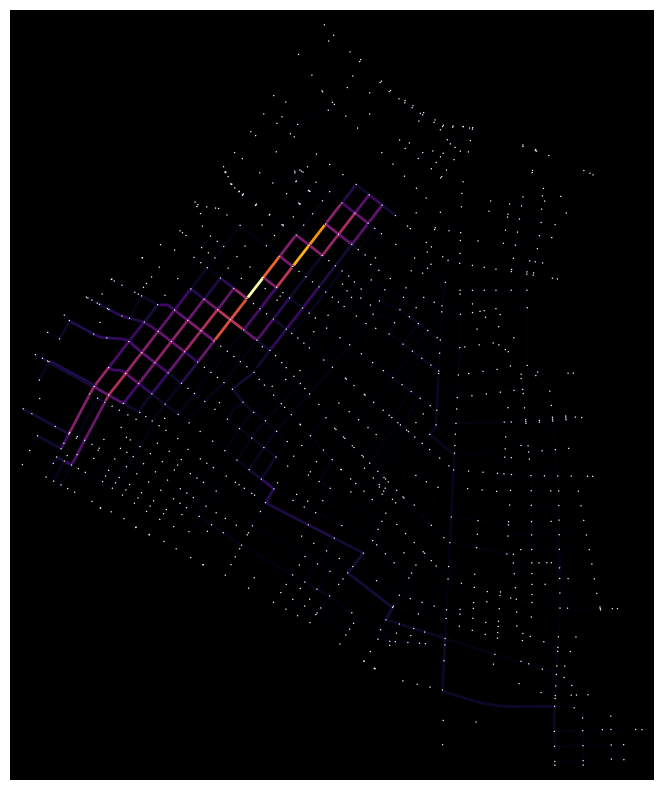

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [40]:
# visualize 'choice' on G_d
fig, ax = plt.subplots(figsize=(10,10))
ec = ox.plot.get_edge_colors_by_attr(G_d, 'choice', cmap='inferno')
ax.set_facecolor('black')
ox.plot_graph(G_d, edge_color=ec, edge_linewidth=2, node_size=1, ax=ax)

# fig.savefig('Image/choice.png', bbox_inches='tight')

Edges with high choice values are concentrated in the left part of the area.

### 2-4. Centrality

Closeness Centrality is one of the indicators for measuring the importance of nodes in space syntax. Closeness Centrality uses the average shortest path distance from one node to all other nodes to quantify its importance. For this research, the line graph is utilized to calculate the Closeness Centrality of each edge, and this value is added as a 'centrality' attribute to the corresponding edge. Through this process, important roads can be identified within the road network that play a significant role in transportation.

- Edges with high closeness centrality values: Edges with high closeness centrality values have shorter average distances to all other edges in the network
- Edges with low closeness centrality values: Edges with low closeness centrality values have longer average distances to other edges

[Source: ScienceDirect](https://www.sciencedirect.com/topics/computer-science/closeness-centrality#:~:text=Closeness%20centrality%20indicates%20how%20close,Consider%20Figure%203.4.)

In [41]:
# calculate centrality
centrality = calculate_centrality(G_d)

In [42]:
pd.Series(centrality).describe()

count    1018.000000
mean        8.462344
std         5.754909
min         0.000000
25%         3.300000
50%         8.606481
75%        13.124238
max        20.100000
dtype: float64

In [43]:
# add attribute
for u, v, data in G_d.edges(data=True):
    data['closeness_centrality'] = (centrality[u] + centrality[v])

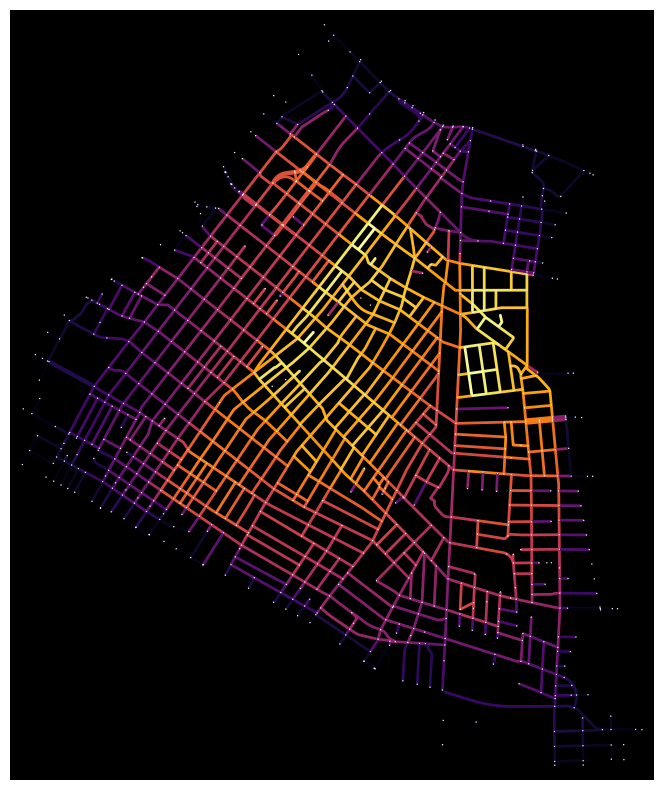

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [44]:
# visualize 'closeness_centrality' on G_d
fig, ax = plt.subplots(figsize=(10,10))
ec = ox.plot.get_edge_colors_by_attr(G_d, 'closeness_centrality', cmap='inferno')
ax.set_facecolor('black')
ox.plot_graph(G_d, edge_color=ec, edge_linewidth=2, node_size=1, ax=ax)

# fig.savefig('Image/closeness_centrality.png', bbox_inches='tight')

The above figure shows that edges located in the central region have higher closeness centrality value.

### 2-5. Integration

Integration is a measure of the degree to which a space is connected to other spaces. This is the calculation of how close or how accessible each spatial element is to all others under each definition of distance, such as the least angular distance.

- Edges with high integration values: Edges wih high integration values are well-connected and accessible to other space
- Edges with low integration values: Edges with low integration values are relatively isolated and disconnected from other spaces

[Source: Space Syntax: Urban Network & Spatial Relations](https://medium.com/data-mining-the-city-2022/space-syntax-urban-network-spatial-relations-7679de91beb#:~:text=Integration%20(Closeness),as%20the%20least%20angular%20distance.)

In [45]:
# calculate shortest path length
shortest_path_lengths = dict(nx.shortest_path_length(G_d))

In [46]:
# calculate the integration of each node in the graph
integration = nx.degree_centrality(G_d)

In [47]:
# calculate integration of each edge in G_d
for u, v, data in G_d.edges(data=True):
    edge_int = (integration[u] + integration[v])
    data['integration'] = edge_int

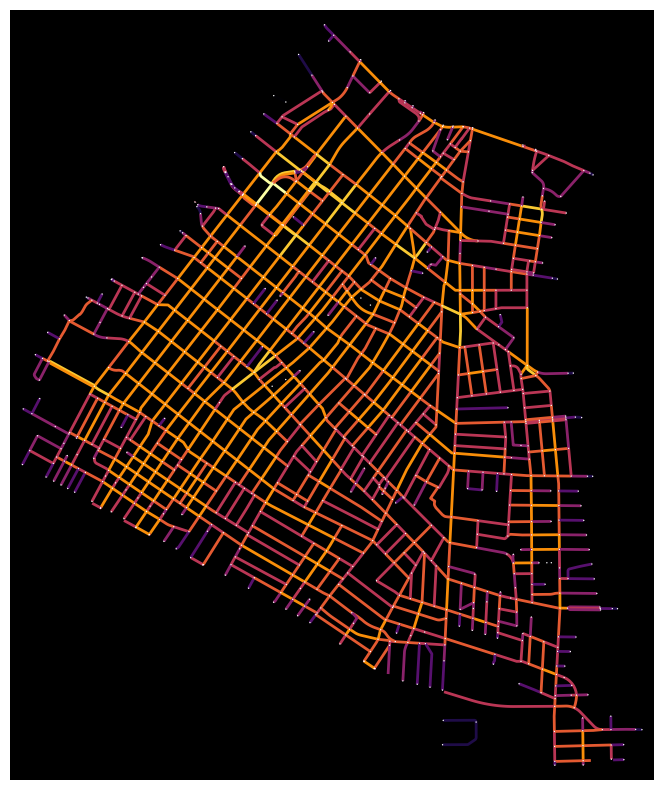

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [48]:
# visualize 'integration' on G_d
fig, ax = plt.subplots(figsize=(10,10))
ec = ox.plot.get_edge_colors_by_attr(G_d, 'integration', cmap='inferno')
ax.set_facecolor('black')
ox.plot_graph(G_d, edge_color=ec, edge_linewidth=2, node_size=1, ax=ax)

# fig.savefig('Image/integration.png', bbox_inches='tight')

Edges in the central region tend to have higher integration values whereas edges in the periphery have lower integration values. Also, there are more edges with higher integration values in the left center as compared to the right center.

## 3. Regression Model

To find out the relationship between space syntax variables and traffic collision, regression analysis was conducted.

In [49]:
# convert G_d to geodataframe
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_d)

In [50]:
# define variables and response
variables = ['connectivity',
             'betweenness',
             'choice',
             'closeness_centrality',
             'integration']

response = 'collision_count'

In [51]:
# set X and Y
# only edges with at least 1 collision were used for the analysis
Y = gdf_edges[[response]][gdf_edges[response]!=0]
X = gdf_edges.loc[Y.index][variables]

In [52]:
# log transformation
# add a small value to avoid taking the log of zero
X_log = np.log(X + 0.00001)
Y_log = np.log(Y + 0.00001)

In [53]:
# create new dataframe with log converted X and Y
log_df = pd.merge(X_log, Y_log, left_index=True, right_index=True)

In [54]:
# add 'geometry' column
log_df['geometry'] = gdf_edges.loc[X.index]['geometry']

In [55]:
# convert log_df to GeoDataFrame
log_df = gpd.GeoDataFrame(log_df, geometry='geometry', crs='EPSG:4326')

In [56]:
log_df

,,,connectivity,betweenness,choice,closeness_centrality,integration,collision_count,geometry
u,v,key,,,,,,,
5370,5372,0,1.098616,6.213681,-9.038894,2.051986,-4.977250,1.609440,"LINESTRING (-118.25081 34.02576, -118.24980 34..."
5372,41759,0,1.098616,6.917706,-8.079741,1.902109,-5.131159,1.791761,"LINESTRING (-118.24980 34.02529, -118.24990 34..."
41759,5393,0,1.386297,4.852030,-11.084656,1.717653,-4.977250,1.945912,"LINESTRING (-118.24990 34.02518, -118.24954 34..."
5384,5387,0,1.386297,9.076833,-6.483408,2.676088,-4.977250,1.791761,"LINESTRING (-118.24307 34.02454, -118.24189 34..."
56312,5399,0,1.098616,6.774681,-10.111194,2.720884,-5.131159,0.000010,"LINESTRING (-118.24213 34.02376, -118.24218 34..."
...,...,...,...,...,...,...,...,...,...
64511,64512,0,0.000010,-11.512925,-11.508247,0.000010,-6.226393,0.693152,"LINESTRING (-118.25347 34.04066, -118.25286 34..."
50801,50802,0,0.000010,-11.512925,-11.508247,0.000010,-6.226393,1.386297,"LINESTRING (-118.24543 34.04616, -118.24621 34..."
66357,66356,0,1.386297,-11.512925,-11.512925,1.547565,-5.313143,2.484907,"LINESTRING (-118.23220 34.05515, -118.23217 34..."


In [57]:
# set x_columns and y_columns
x_columns = variables
y_column = 'collision_count'

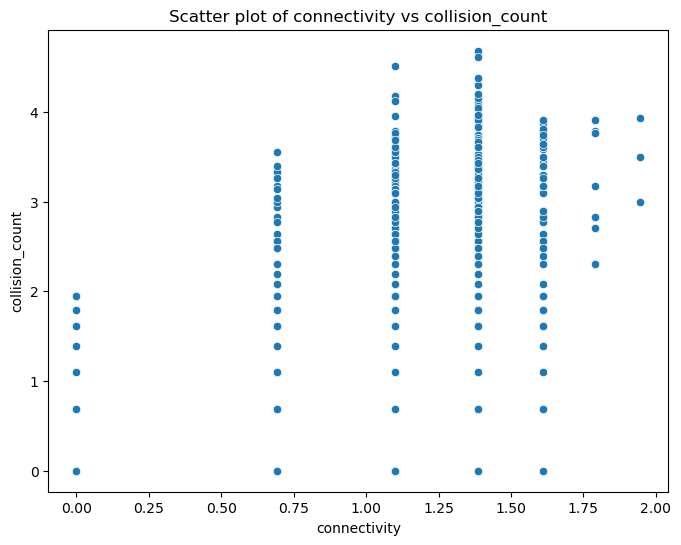

connectivity vs collision_count - Pearson correlation coefficient: 0.305


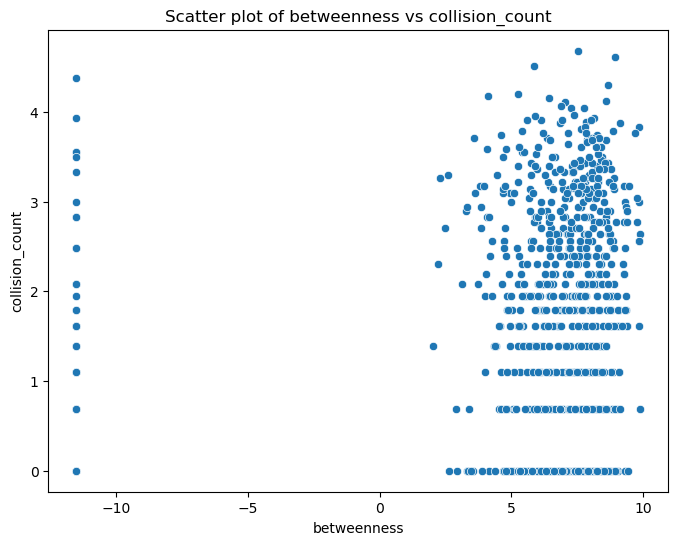

betweenness vs collision_count - Pearson correlation coefficient: 0.099


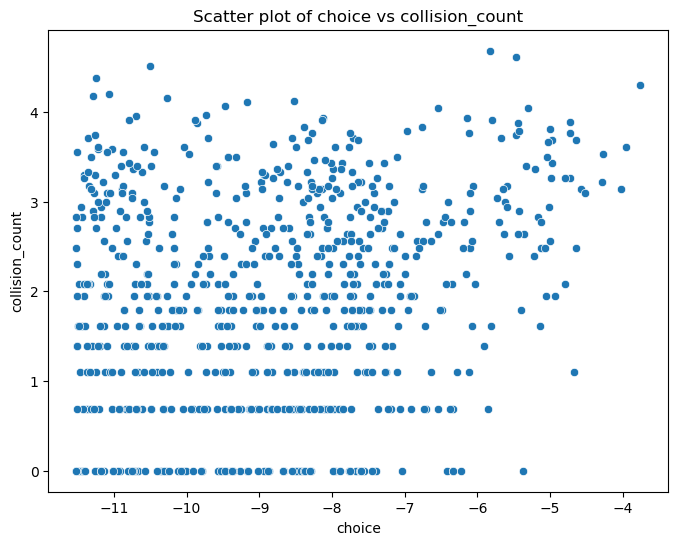

choice vs collision_count - Pearson correlation coefficient: 0.213


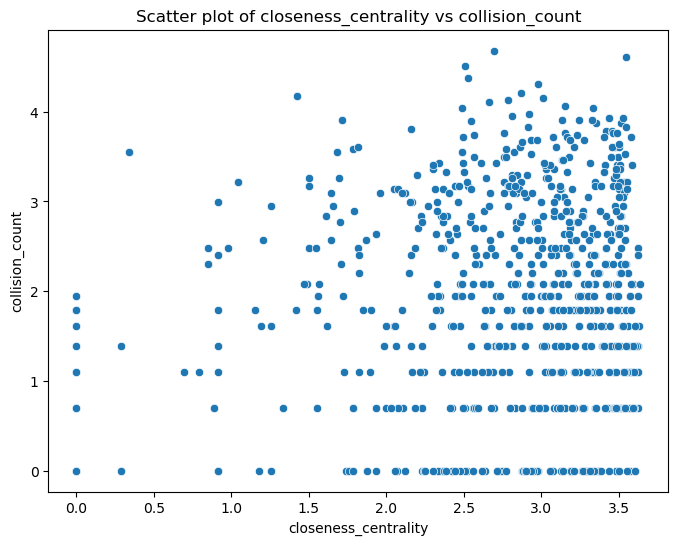

closeness_centrality vs collision_count - Pearson correlation coefficient: 0.094


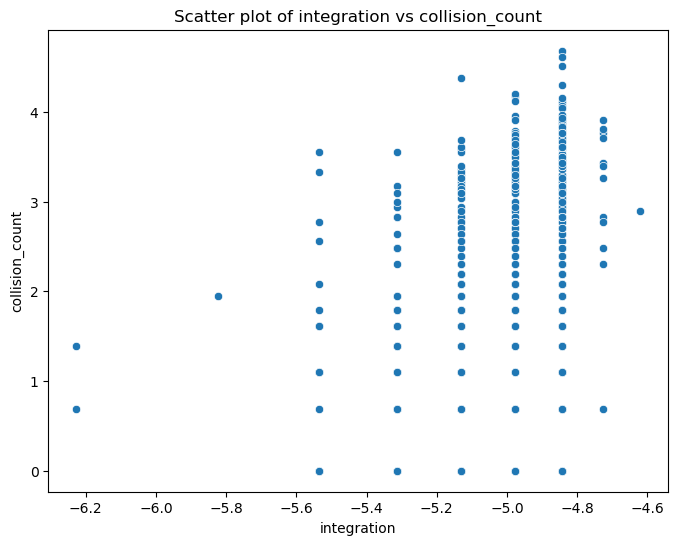

integration vs collision_count - Pearson correlation coefficient: 0.365


In [58]:
# check linearity of X and Y
for x_column in x_columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=log_df, x=x_column, y=y_column)
    plt.title("Scatter plot of {} vs {}".format(x_column, y_column))
    # plt.savefig("Image/{}_vs_{}_scatter.png".format(x_column, y_column), bbox_inches='tight')
    plt.show()
    
    correlation_coefficient = log_df[[x_column, y_column]].corr(method='pearson').iloc[0, 1]
    print("{} vs {} - Pearson correlation coefficient: {:.3f}".format(x_column, y_column, correlation_coefficient))


Upon observing that all X variables exhibited a low degree of linearity with respect to the Y variable, it was hypothesized that OLS analysis may not be the most appropriate method. However, to explore the relationship between the independent variables an Ordinary Least Squares (OLS) analysis was conducted.

### 3-1. OLS

In [59]:
# define threshold
x = log_df.centroid.x
y = log_df.centroid.y
coords = np.array([x, y]).T
d_threshold = weights.min_threshold_distance(coords)
d_threshold

/var/folders/nh/bgd128891hxd7ggprg1zgbhm0000gn/T/ipykernel_52512/2660336036.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x = log_df.centroid.x
/var/folders/nh/bgd128891hxd7ggprg1zgbhm0000gn/T/ipykernel_52512/2660336036.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y = log_df.centroid.y


0.003342269117481986

In [60]:
# create weight
d_w = weights.distance.DistanceBand.from_dataframe(log_df, threshold=d_threshold)
d_w.transform = 'r'

('WARNING: ', (5792, 9637, 0), ' is an island (no neighbors)')


/Users/kweon-youngseo/miniforge3/envs/ppd599/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: (5792, 9637, 0).
  warnings.warn(message)


In [61]:
# compute OLS spatial diagnostics to check the nature of spatial dependence
ols = spreg.OLS(y=Y_log.values,
                x=X_log.values,
                w=d_w,
                name_x=X_log.columns.tolist(),
                name_y='collision_count',
                name_ds='Downtown'
               )

In [62]:
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :    Downtown
Weights matrix      :     unknown
Dependent Variable  :collision_count                Number of Observations:         726
Mean dependent var  :      1.9470                Number of Variables   :           6
S.D. dependent var  :      1.1540                Degrees of Freedom    :         720
R-squared           :      0.1778
Adjusted R-squared  :      0.1721
Sum squared residual:     793.758                F-statistic           :     31.1415
Sigma-square        :       1.102                Prob(F-statistic)     :     9.7e-29
S.E. of regression  :       1.050                Log likelihood        :   -1062.539
Sigma-square ML     :       1.093                Akaike info criterion :    2137.079
S.E of regression ML:      1.0456                Schwarz criterion     :    2164.604

--------------------------------------------------------------------------

The results show that "connectivity" was positively related to traffic collision at the 0.1 level of significance, while "integration" and "choice" were positively related to traffic collision at the 0.01 level of significance. Additionally, "betweenness" was negatively related to traffic collision at the 0.01 level of significance, and "closeness_centrality" was negatively related to traffic collision at the 0.1 level of significance. However, R-squared value of 0.1780 and adjusted R-squared value of 0.1723 are low and therefore a more suitable model is needed for the data.

### 3-2. GWR
Upon determining that the previously conducted model was not adequately fitting the data, a Geographically Weighted Regression (GWR) was implemented to further scrutinize the influence of variables. 

Gaussian spatial kernel was employed to comparatively assess the outcomes. The Gaussian kernel follows a normal distribution and is the most commonly used kernel function for assigning weights based on distance. As the distance from the central point increases, the weights gradually decrease, resulting in a curve that resembles the shape of a normal distribution.

In [63]:
fixed_kernel = False
criterion = 'AICc'
spatial_kernel = 'gaussian'

In [64]:
%%time
# select an adaptive (NN) bandwidth for our GWR model, given the data
centroids = log_df.centroid
coords = list(zip(centroids.x, centroids.y))

# manually set the bandwidth to see how the model and visualization change
nn = 25

CPU times: user 13.3 ms, sys: 2.3 ms, total: 15.6 ms
Wall time: 15.5 ms


<timed exec>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [65]:
%%time
# estimate the GWR model parameters
model = mgwr.gwr.GWR(coords=coords,
                     y=Y_log.values,
                     X=X_log.values,
                     bw=nn,
                     kernel=spatial_kernel,
                     fixed=fixed_kernel)
gwr = model.fit()

CPU times: user 922 ms, sys: 146 ms, total: 1.07 s
Wall time: 1.19 s


In [66]:
# inspect the results
gwr.summary()

Model type                                                         Gaussian
Number of observations:                                                 726
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            793.758
Log-likelihood:                                                   -1062.539
AIC:                                                               2137.079
AICc:                                                              2139.235
BIC:                                                              -3949.278
R2:                                                                   0.178
Adj. R2:                                                              0.172

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

Utilizing the Gaussian spatial kernel with a bandwidth of 25, the Residual Sum of Squares (RSS) value decreased to 595.450 compared to the Ordinary Least Squares (OLS) model value of 793.603. The corrected Akaike Information Criterion (AICc) also decreased to 2091.128 compared to the OLS analysis value of 2139.093. Additionally, the Adjusted R-squared value increased to 0.310 compared to the OLS model value of 0.172. These results indicate that the model is more suitable for the data, and the outcomes have been visualized accordingly.

In [67]:
# a constant was added, add it to predictors
cols = ['constant'] + variables
cols

['constant',
 'connectivity',
 'betweenness',
 'choice',
 'closeness_centrality',
 'integration']

In [68]:
# turn GWR local parameter estimates into a GeoDataFrame with d_edges_gdf geometries
params = pd.DataFrame(gwr.params, columns=cols, index=X_log.index)
params = log_df[['geometry']].merge(params, left_index=True, right_index=True, how='right')
params.head()

,,,geometry,constant,connectivity,betweenness,choice,closeness_centrality,integration
u,v,key,,,,,,,
5370,5372,0,"LINESTRING (-118.25081 34.02576, -118.24980 34...",1.745672,-0.037599,-0.074547,0.257246,0.071767,-0.488349
5372,41759,0,"LINESTRING (-118.24980 34.02529, -118.24990 34...",2.783122,-0.116634,-0.070596,0.254178,0.031902,-0.311950
41759,5393,0,"LINESTRING (-118.24990 34.02518, -118.24954 34...",5.254581,-0.253229,-0.060109,0.248094,-0.057778,0.123219
5384,5387,0,"LINESTRING (-118.24307 34.02454, -118.24189 34...",11.564245,-0.108507,-0.012872,0.219632,-0.415845,1.333881
56312,5399,0,"LINESTRING (-118.24213 34.02376, -118.24218 34...",11.838897,-0.114153,-0.039719,0.241804,-0.316595,1.364941


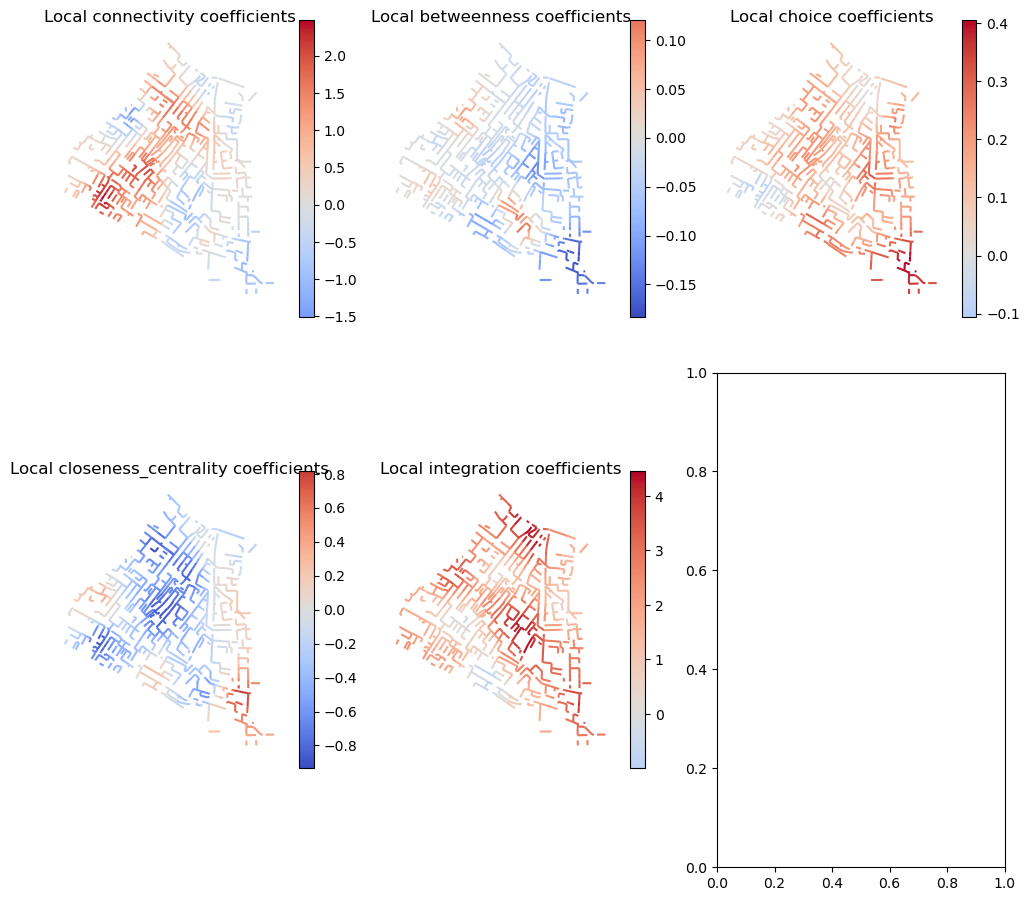

In [69]:
# plot the spatial distribution of local parameter estimates
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
for col, ax in zip(variables, axes.flat):
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'Local {col} coefficients')
    gdf = params.dropna(subset=[col], axis='rows')
    ax = gdf.plot(ax=ax,
                  column=col,
                  cmap=get_cmap(gdf[col]),
                  legend=True,
                  legend_kwds={'shrink': 0.6})
fig.tight_layout()

In [70]:
# this code is for saving image
# for col in variables:
#     fig, ax = plt.subplots(figsize=(10,10))
#     ax.set_aspect('equal')
#     ax.axis('off')
#     gdf = params.dropna(subset=[col], axis='rows')
#     ax = gdf.plot(ax=ax,
#                   column=col,
#                   cmap=get_cmap(gdf[col]),
#                   legend=True,
#                   legend_kwds={'shrink': 0.6})
#     fig.tight_layout()
#     fig.savefig(f'Image/GWR {col}.png', bbox_inches='tight')

Through the visualization, it becomes evident how each variable impacts the occurrence of traffic accidents on downtown roads. Within the same region, the areas where each variable exerts a significant influence differ, as does the direction of the relationship, whether positive or negative. Based on these insights, it can be concluded that the Geographically Weighted Regression (GWR) model is the most appropriate method for exploring the relationship between space syntax variables and traffic collisions.

## 4. Conclusion
Upon examining the results of GWR, it was discovered that each variable has different correlations with traffic collisions depending on the road. However, the results still have room for improvement, and to increase accuracy in future research, depthmapX, the original method for calculating space syntax attributes, could be utilized. Additionally, analyzing larger areas could provide a better understanding of the relationships between space syntax and traffic collisions.